In [2]:
#Load packages and data
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import itertools
%matplotlib inline


path= '/Users/shubpuri/Downloads/Rewards Network Test/datasets_sample_dines_data.csv'
dines=pd.read_csv('/Users/shubpuri/Downloads/Rewards Network Test/datasets_sample_dines_data.csv')


# Converting the 'Date' column into Index

In [3]:
dines['Date']= pd.to_datetime(dines['Date'])
dines = dines.set_index('Date')
dines.index

DatetimeIndex(['2014-01-01 05:49:00', '2014-01-02 05:49:00',
               '2014-01-03 05:49:00', '2014-01-04 05:49:00',
               '2014-01-05 05:49:00', '2014-01-06 05:49:00',
               '2014-01-07 05:49:00', '2014-01-08 05:49:00',
               '2014-01-09 05:49:00', '2014-01-10 05:49:00',
               ...
               '2018-12-22 05:49:00', '2018-12-23 05:49:00',
               '2018-12-24 05:49:00', '2018-12-25 05:49:00',
               '2018-12-26 05:49:00', '2018-12-27 05:49:00',
               '2018-12-28 05:49:00', '2018-12-29 05:49:00',
               '2018-12-30 05:49:00', '2018-12-31 05:49:00'],
              dtype='datetime64[ns]', name='Date', length=1826, freq=None)

In [4]:
dines.head()

sales
Date                      
2014-01-01 05:49:00   1742
2014-01-02 05:49:00   1808
2014-01-03 05:49:00   1887
2014-01-04 05:49:00   1983
2014-01-05 05:49:00   2087

In [148]:
dines.dtypes

sales    int64
dtype: object

# Model 1: Creating a baseline model
The forecasted values are creating by shifting the current value by 1 timeframe ahead

In [149]:

val=dines.values
value= pd.DataFrame(val)
dines_df= pd.concat([value, value.shift(1)], axis=1)
dines_df.columns= ['Current', 'Forecast']
#Removing Na
dines_df= dines_df[1:]
dines_df.tail()

Current  Forecast
1821     2624    2581.0
1822     2839    2624.0
1823     3025    2839.0
1824     3151    3025.0
1825     3370    3151.0

In [151]:
from sklearn.metrics import mean_squared_error
import numpy as np
dines_error = mean_squared_error(dines_df.Current, dines_df.Forecast)
#This is the baseline model
np.sqrt(dines_error)

579.6616150351906

Clearly, This model has a very high error rate. This isn't an accurate model.
So, we move on by creating further models.

# Model 2  ARIMA : Taking a monthly average of the sales data for each year

In [75]:
monthavg = dines['sales'].resample('MS').mean()

In [7]:
monthavg.head()

Date
2014-01-01    1887.741935
2014-02-01    2120.857143
2014-03-01    2568.032258
2014-04-01    2932.900000
2014-05-01    3172.935484
Freq: MS, Name: sales, dtype: float64

In [8]:
dines.head()

sales
Date                      
2014-01-01 05:49:00   1742
2014-01-02 05:49:00   1808
2014-01-03 05:49:00   1887
2014-01-04 05:49:00   1983
2014-01-05 05:49:00   2087

In [37]:
from statsmodels.tsa.stattools import adfuller

# Performing the test of Stationarity.
Test 1: Rolling Statistics test       
Test 2: Dickey fuller test

In [12]:
def test_stationarity(timeseries):
    #Determining rolling statistics
    movingaverage = timeseries.rolling(window=12).mean()
    movingSTDev= timeseries.rolling(window=12).std()
    
    #Plot ROlling statistics:
    orig = plt.plot(timeseries, color='blue', label='original')
    mean= plt.plot(movingaverage, color='red', label = 'Rolling Mean')
    std = plt.plot(movingSTDev, color='black', label = 'Rolling STD')
    plt.legend(loc='best')
    plt.title("Rolling mean & Stdev")
    plt.show(block=False)
    

    #Perform dickeyfuller test
    print('Results of Dickey Fuller test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#lags','#observ'])
    for key,value in dftest[4].items():
        dfoutput['Critical value(%s)'%key] = value
    print(dfoutput)

In [13]:
test_stationarity(monthavg)

Results of Dickey Fuller test:
Test Statistic         -4.975549
p-value                 0.000025
#lags                  11.000000
#observ                48.000000
Critical value(1%)     -3.574589
Critical value(5%)     -2.923954
Critical value(10%)    -2.600039
dtype: float64


# P value is <0.05 and critical value > Test Statistic. So this data is stationary!

In [38]:
monthavg.plot(figsize=(15, 6))
plt.show()

This shows that average monthly sales are highest at the middle of each year and low in the beginning of the year,
There's also a seasonal trend during december and a drop of sales at the end of year.
The mean of the yearly sales is increasing by each year and the data shows an upward trend in the average sales amount.

In [40]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(monthavg, model='additive')
fig = decomposition.plot()
plt.show()

Insights from the graph:
    1. Trend is upwards for each coming year
    2. There is a noticable seasonal pattern observed in each year.
    3. The sales are unstable

# Creating a function to find the parameters p,q,d for ARIMA model

In [16]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [17]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthavg,order=param,seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1130.4037531077595
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:853.1597514254381
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:664.0299784460369


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1618.0306218140493
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:616.3249731932112
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:593.7117287336869
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:463.7836926371424
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1405.8855898653799
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1045.0275672753157
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:787.5245783980025
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:603.3384784866631


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1118.9841672325606
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:585.1857606181595


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:557.4466194362468
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:445.6042523300353


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1146.7617961015076
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:873.0963701494139
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:661.3491181924535
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:536.2588458898113


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1402.7703553477536
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:544.3638529352604
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:529.2911270618358
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:403.60019790878863


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1354.6014592613967
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:858.2916143564848
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:647.1483831433877
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:525.9432748520591


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1288.5449933294942
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:543.2321244593056


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:526.0854668597871
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:400.0150855067844


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1291.1018265889495
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:889.3073081221434
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:677.2538648856382
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:547.4620463659883
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1487.5119569980372
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:542.4961086316101
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:537.5757444045101
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:404.913772422505
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1407.8855898653628
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:875.0969379712719
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:664.2817869725183
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:537.805027569701


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1480.235807394015
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:542.6391951963043
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:525.9758716369839
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:402.46643835886687


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1401.0338694133823
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:872.6312168712847
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:661.3297267675565
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:537.3265748957562


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1277.6240068683003
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:533.1394329141674


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:536.5156014389642
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:390.1949089903608


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1482.216523885667
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:859.5819663155878
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:649.0321591736433
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:527.8960953179629


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1278.7037289913708
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:534.6583700071627
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:517.4467765846421
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:390.1238292339853
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1281.299426091837


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


# So these are our optimal parameters p,q,d for the model.
The above method says that the lowest AIC is 390.123 for ARIMA(1, 1, 1)x(1, 1, 0, 12)12

# Fitting the model

In [18]:
mod = sm.tsa.statespace.SARIMAX(monthavg,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5530      0.150      3.697      0.000       0.260       0.846
ma.L1         -1.0000      0.262     -3.821      0.000      -1.513      -0.487
ar.S.L12      -0.2650      0.119     -2.221      0.026      -0.499      -0.031
sigma2      4209.7506   6.22e-05   6.77e+07      0.000    4209.750    4209.751


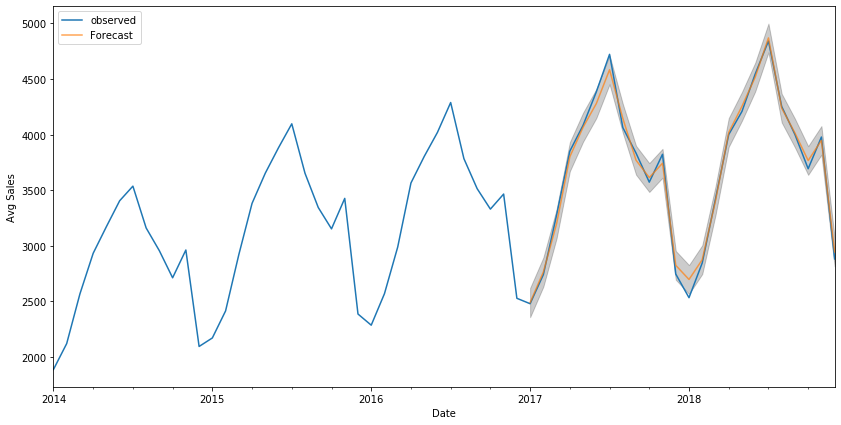

In [44]:
#Predicting on test data which is from 2017-2019

pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = monthavg['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Avg Sales')
plt.legend()
plt.show()

In [41]:
prediction= pred.predicted_mean
test=monthavg['2017':]

# Mean squared error and Root mean squared error of the Test data

In [25]:
from sklearn.metrics import mean_squared_error
arima_error = mean_squared_error(test,prediction)


In [26]:

print(arima_error)
np.sqrt(arima_error)

4496.6159295881125


67.05681120951184

# Forecast for average monthly sales in 2019 and 2020


In [152]:
forecast = results.forecast(steps=24)
forecast

2019-01-01    2742.808811
2019-02-01    3058.668436
2019-03-01    3632.997118
2019-04-01    4215.906017
2019-05-01    4432.980962
2019-06-01    4761.381200
2019-07-01    5070.015448
2019-08-01    4463.527147
2019-09-01    4217.315072
2019-10-01    3921.863232
2019-11-01    4198.115855
2019-12-01    3106.708464
2020-01-01    2948.077856
2020-02-01    3263.146418
2020-03-01    3837.801528
2020-04-01    4419.679190
2020-05-01    4634.300405
2020-06-01    4964.802420
2020-07-01    5270.336282
2020-08-01    4668.627312
2020-09-01    4420.781618
2020-10-01    4122.011447
2020-11-01    4400.663862
2020-12-01    3307.872145
Freq: MS, dtype: float64

In [153]:
forecast.to_csv (r'/Users/shubpuri/Downloads/Rewards Network Test/Time Series Forecast.csv', index=False)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


# Model 3 : Using FBProphet model on the original daily sales data
Prophet is a package by Facebook which is used for detailed time series analysis.

In [115]:
dines1=pd.read_csv('/Users/shubpuri/Downloads/Rewards Network Test/datasets_sample_dines_data.csv')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

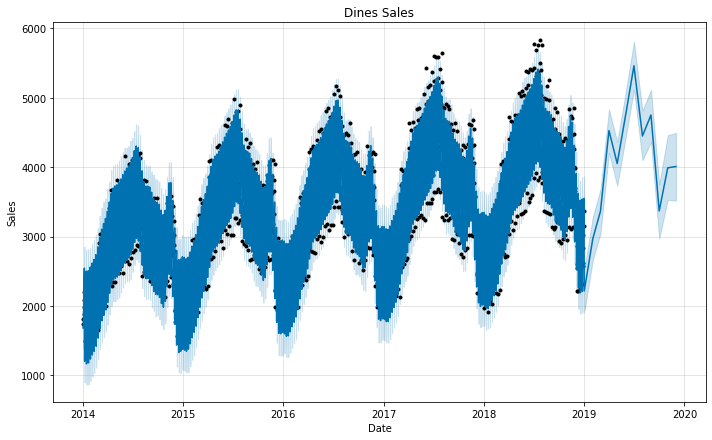

In [139]:
from fbprophet import Prophet
dines1 = dines1.rename(columns={'Date': 'ds', 'sales': 'y'})
dines1_model = Prophet(interval_width=0.95)
dines1_model.fit(dines1)

dines1_forecast = dines1_model.make_future_dataframe(periods=12, freq='MS')
dines1_forecast = dines1_model.predict(dines1_forecast)

plt.figure(figsize=(18, 6))
dines1_model.plot(dines1_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Dines Sales');

plot of the data and predictions for the next few years

Text(0, 0.5, 'Sales')

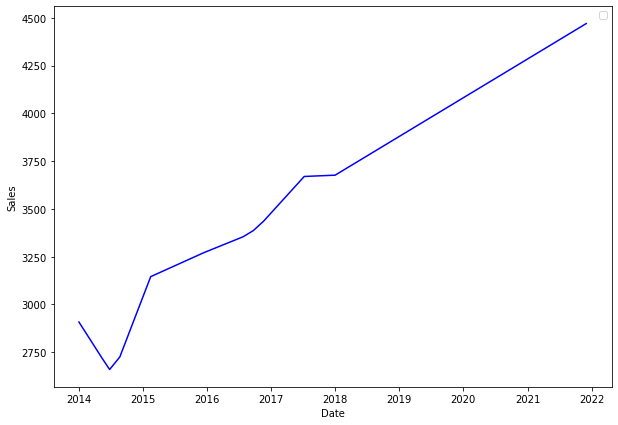

In [107]:
plt.figure(figsize=(10, 7))
plt.plot(dines1_forecast['ds'], dines1_forecast['trend'], 'b-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')


There was a sudden drop of sales from 2014-2015 but the sales have been consistently upwards after that.

Text(0, 0.5, 'Sales')

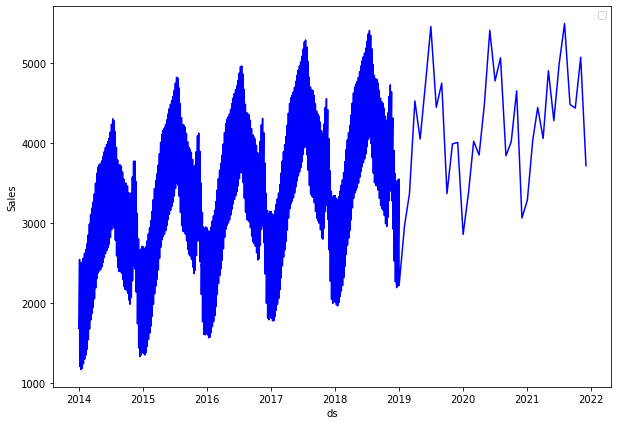

In [208]:
plt.figure(figsize=(10, 7))
plt.plot(dines1_forecast['ds'], dines1_forecast['yhat'], 'b-')

plt.legend(); plt.xlabel('ds'); plt.ylabel('Sales')


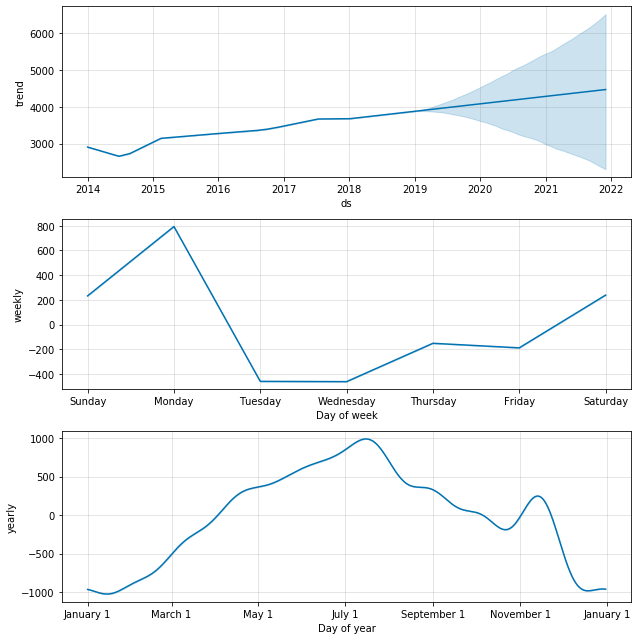

In [209]:
dines1_model.plot_components(dines1_forecast);

# Let's look at the weekly sales and yearly sales from the graphs above
    Weekly sales: The sales on monday is the highest of all weeks except there's a drop from tuesday where the 
                  sales hit the weekly lowest. From Thursday till sunday the sales go up again.
                  Reason for these fluctuations is because people tend to go out less during the middle of the week 
                  compared to the end of the week. Also, Weekend have more hours for dining due to 
                  holidays from work.
    
    Yearly sales: The sales number is the lowest during the start of the year but suddenly hit its all time high
                  during the middle of the year in July. This could be because of the holiday season for various
                  age groups. From September the daily sales start to fall until the next january. 
                  However, there is a another hike in the sales between december - January. This is because of 
                  the holiday season where people tend to dine outside more often than normal days.

# Advice to the management
The store has an upward trend for its sales, however, During the first half of the year until July, the sales number keep on increasing slowly ultimately reaching its highest point. This is the time when the store might want to have a significant number of employees working at the restaurant to ensure that all customers are being served and the store is not losing any sales due to lack of employees.
After July, during the second half of the year, the sales start to decrease. During this period, the employee count does not have to be maximum in order to save some cost. Other than that, store should be prepared to come up with various offers for potential diners in order to increase the declining sales number. Also, During december, the sales suddenly tend to increase due to seasonality effect and the store should be prepared with numerous deals in order to maximize the profit during that period.
On a weekly basis, the store sales tend to decrease during the middle of the week and slowly increase by the end of the week.
If the store can come up with a solution to increase the sales during the middle of the week, there is a potential to increase the average monthly sales hence leading to more profit.
